# Tunning Convolutional Nural network with Large filters

In [25]:
## For google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir("/content/drive/My Drive/SENG474-FinalProject")

Mounted at /content/drive


## Loading in the data set

The data used in this project comes for the ALASKA 2 data set from Kagel

In [26]:
!ls

images	SRM_Kernels1.npy   Steganography_CNN_Deep  X_256.pickle  y_256.pickle
logs	Steganography_CNN  X_100.pickle		   y_100.pickle


Loading data which is in pickle format

In [27]:
import pickle

with open("X_100.pickle", 'rb') as pickle_in:
    X = pickle.load(pickle_in)

with open("y_100.pickle", 'rb') as pickle_in:
    y = pickle.load(pickle_in)

In [ ]:
import numpy as np

IMG_SIZE = 100

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

y = np.array(y).reshape(-1, 1)


Listing the first 10 images from the dataset

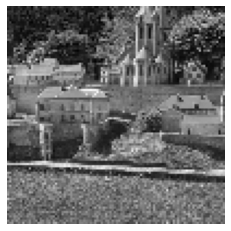

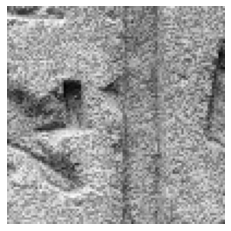

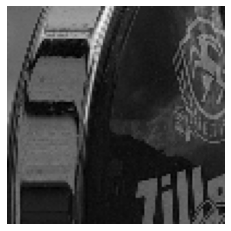

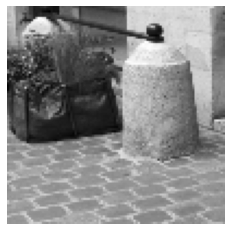

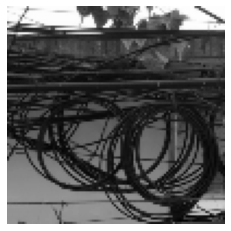

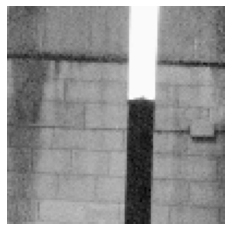

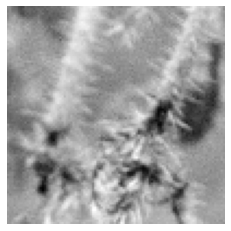

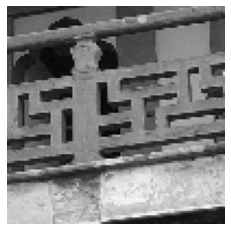

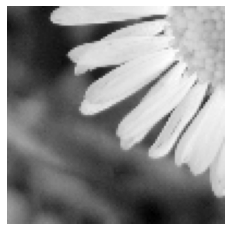

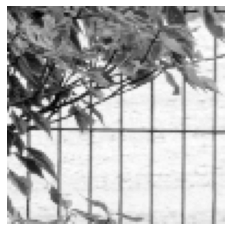

In [28]:
from matplotlib import pyplot as plt

for i in range(10):
  fig, ax = plt.subplots(1,1)
  ax.imshow(X[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
  ax.axis('off')

plt.show()

In [29]:
!pip install keras-tuner --upgrade;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Here is the definition of the model notice that the second layer, Kernal, almost covers the entirety of the input. In theory, this is the case as the feature is in the entire image.

In [30]:
from tensorflow.keras.layers import Rescaling
import keras_tuner
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_shape = (100, 100, 1)

def call_existing_code(activation, dropout, dr, lr, momentum):
  inputs = keras.Input(input_shape)

  # scale down to proper size
  x = Rescaling(scale=1.0 / 255)(inputs)

  # this model is based off of large convolution filters

  x = layers.Conv2D(filters=1, kernel_size=3, activation=activation)(x)
  x = layers.Conv2D(filters=64, kernel_size=96, activation=activation)(x)
  x = layers.Flatten()(x)

  x = layers.Dense(units = 64*4)(x)
  if dropout: 
    x = layers.Dropout(rate = dr)(x)

  # input is ether stegano or not
  number_of_classes = 1
  
  output = layers.Dense(number_of_classes, activation="sigmoid")(x)

  model = keras.Model(inputs, output, name="Steganography_CNN")

  model.compile(
      optimizer=keras.optimizers.SGD(learning_rate = lr, momentum = momentum),
      loss="binary_crossentropy",
      metrics=['accuracy']
      )

  return model

def get_model(hp):
  activation = hp.Choice("activation", ['relu', 'tanh'])
  dropout = hp.Boolean("dropout")
  dr = hp.Float('dr', min_value=0.1, max_value=0.5,  sampling="log")
  lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  momentum = hp.Float("momentum", min_value=1e-4, max_value=0.9, sampling="log")
  
  model = call_existing_code(activation, dropout, dr, lr, momentum)

  return model

model = get_model(keras_tuner.HyperParameters())

model.summary()

Model: "Steganography_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 100, 100, 1)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 98, 98, 1)         10        
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 3, 64)          589888    
                                                                 
 flatten_1 (Flatten)         (None, 576)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               147712    
                                                                 
 dense_3 (Dense)             (None, 1)           

## Tuning Hyper Perameters

This section tunes the hyper paramaters on the model from 1% of the dataset

In [ ]:
per = 1

idx = np.random.choice(np.arange(len(X)), int(len(X)*(per/100)), replace=False)

X_s = X[idx]
y_s = y[idx]

len(y_s)

1000

Listing the first 10 images from the tunning set

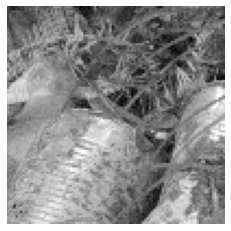

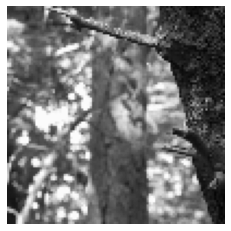

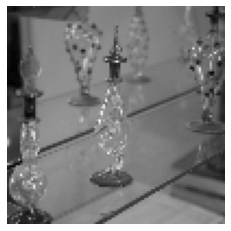

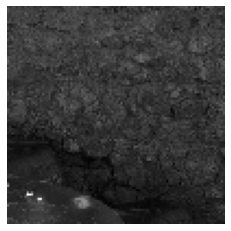

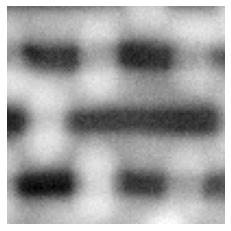

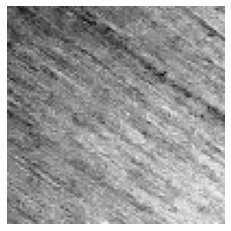

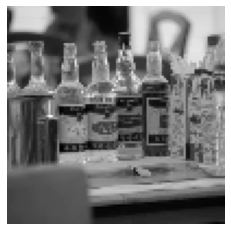

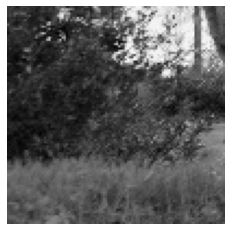

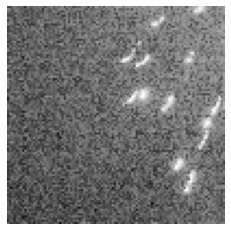

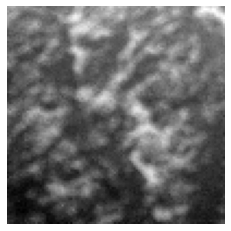

In [ ]:
from matplotlib import pyplot as plt

for i in range(10):
  fig, ax = plt.subplots(1,1)
  ax.imshow(X_s[i].reshape(100, 100), cmap='gray')
  ax.axis('off')

plt.show()

In [ ]:
!pwd

/content/drive/MyDrive/SENG474-FinalProject


Establishing the location where the parameters are stored

In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=get_model,
    objective="val_accuracy",
    max_trials=40,
    executions_per_trial=2,
    overwrite=True,
    directory=
    "/content/drive/MyDrive/SENG474-FinalProject",
    project_name = "Steganography_CNN_Deep"
    
)

tuner.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
dr (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': 'log'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
momentum (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.9, 'step': None, 'sampling': 'log'}


In [ ]:
from sklearn.model_selection import train_test_split

X_tune_train, X_tune_test, y_tune_train, y_tune_test = train_test_split(X_s, y_s, test_size=0.10, random_state=1337)


Converting the data to tensors

Running the tuner

In [ ]:
tuner.search(X_tune_train, y_tune_train, epochs=5, validation_data=(X_tune_test, y_tune_test))

Trial 40 Complete [00h 00m 35s]
val_accuracy: 0.5049999952316284

Best val_accuracy So Far: 0.5649999976158142
Total elapsed time: 00h 25m 43s


In [ ]:
tuner.get_best_hyperparameters()[0]

Printing out the results

In [ ]:
tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/SENG474-FinalProject/Steganography_CNN_Deep
Showing 10 best trials
Trial summary
Hyperparameters:
activation: tanh
dropout: True
dr: 0.3570044401464973
lr: 0.0006654334507308442
momentum: 0.012845717287101408
Score: 0.5649999976158142
Trial summary
Hyperparameters:
activation: relu
dropout: False
dr: 0.39579549638366834
lr: 0.00018702715280418566
momentum: 0.4748541440860422
Score: 0.5600000023841858
Trial summary
Hyperparameters:
activation: relu
dropout: True
dr: 0.1003208925387479
lr: 0.003517438788693305
momentum: 0.00703007294587112
Score: 0.5449999868869781
Trial summary
Hyperparameters:
activation: tanh
dropout: True
dr: 0.2777794374972296
lr: 0.006128566224626864
momentum: 0.8579966241007535
Score: 0.5399999916553497
Trial summary
Hyperparameters:
activation: tanh
dropout: True
dr: 0.15796366302616077
lr: 0.006936536084698388
momentum: 0.10229396897448924
Score: 0.5349999964237213
Trial summary
Hyperparameters:
activation: tanh
